# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

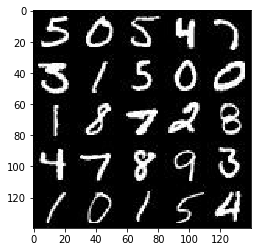

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

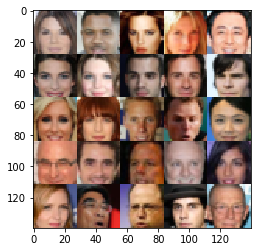

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width,image_height,image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, None, name='learning_rate')

    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 16x16x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 8x8x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x256

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits  
    

   


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    alpha = 0.2
    
    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 4x4x512 now
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 8x8x256 now
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 16x16x128 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 3, strides=1, padding='same')
        # 32x32x3 now
        
        out = tf.tanh(logits)
        
        return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    smooth = 0.1
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real) * (1 - smooth)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss
    


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt
    

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    _, image_width, image_height, image_channels = data_shape
    input_real, input_z, lr = model_inputs(image_width, image_height, image_channels, z_dim)
    disc_loss, gen_loss = model_loss(input_real, input_z, image_channels)
    disc_opt, gen_opt = model_opt(disc_loss, gen_loss, lr, beta1)

    
    saver = tf.train.Saver()
    losses = []
    steps = 0
    total_steps = epoch_count * batch_size

    print_every = 10
    show_every = 100
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_images *= 2
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(
                    disc_opt, 
                    feed_dict={
                        input_real: batch_images, input_z: batch_z, lr: learning_rate 
                    }
                )
                _ = sess.run(
                    gen_opt, 
                    feed_dict={
                        input_real: batch_images, 
                        input_z: batch_z, 
                        lr:learning_rate
                    }
                )
                
                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = disc_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = gen_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, 25, input_z, image_channels, data_image_mode)

        saver.save(sess, './generator.ckpt')
    
    return losses

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.3518... Generator Loss: 6.5648
Epoch 1/2... Discriminator Loss: 0.3465... Generator Loss: 5.8033
Epoch 1/2... Discriminator Loss: 0.4015... Generator Loss: 5.8100
Epoch 1/2... Discriminator Loss: 0.3469... Generator Loss: 5.4870
Epoch 1/2... Discriminator Loss: 0.3436... Generator Loss: 4.7530
Epoch 1/2... Discriminator Loss: 1.5751... Generator Loss: 3.3671
Epoch 1/2... Discriminator Loss: 0.3916... Generator Loss: 3.8563
Epoch 1/2... Discriminator Loss: 1.1125... Generator Loss: 1.4096
Epoch 1/2... Discriminator Loss: 0.6468... Generator Loss: 2.0816
Epoch 1/2... Discriminator Loss: 1.6896... Generator Loss: 0.4105


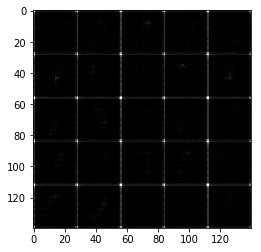

Epoch 1/2... Discriminator Loss: 1.3059... Generator Loss: 0.6794
Epoch 1/2... Discriminator Loss: 1.1513... Generator Loss: 2.1947
Epoch 1/2... Discriminator Loss: 1.5380... Generator Loss: 0.4938
Epoch 1/2... Discriminator Loss: 1.1936... Generator Loss: 1.0207
Epoch 1/2... Discriminator Loss: 1.6159... Generator Loss: 0.4576
Epoch 1/2... Discriminator Loss: 1.4065... Generator Loss: 2.1542
Epoch 1/2... Discriminator Loss: 1.1844... Generator Loss: 1.7562
Epoch 1/2... Discriminator Loss: 1.4216... Generator Loss: 1.9462
Epoch 1/2... Discriminator Loss: 1.0839... Generator Loss: 0.9212
Epoch 1/2... Discriminator Loss: 1.0317... Generator Loss: 1.1120


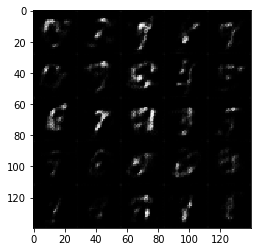

Epoch 1/2... Discriminator Loss: 1.3982... Generator Loss: 0.5394
Epoch 1/2... Discriminator Loss: 1.1432... Generator Loss: 1.6650
Epoch 1/2... Discriminator Loss: 1.1215... Generator Loss: 0.8222
Epoch 1/2... Discriminator Loss: 1.0186... Generator Loss: 1.9681
Epoch 1/2... Discriminator Loss: 1.0986... Generator Loss: 0.8378
Epoch 1/2... Discriminator Loss: 1.1837... Generator Loss: 1.7644
Epoch 1/2... Discriminator Loss: 1.1268... Generator Loss: 1.1327
Epoch 1/2... Discriminator Loss: 1.0321... Generator Loss: 1.1559
Epoch 1/2... Discriminator Loss: 1.0794... Generator Loss: 0.8421
Epoch 1/2... Discriminator Loss: 1.0219... Generator Loss: 1.0597


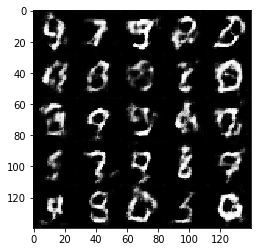

Epoch 1/2... Discriminator Loss: 1.3564... Generator Loss: 1.7696
Epoch 1/2... Discriminator Loss: 1.3150... Generator Loss: 0.5847
Epoch 1/2... Discriminator Loss: 1.3508... Generator Loss: 1.5597
Epoch 1/2... Discriminator Loss: 1.5263... Generator Loss: 0.4763
Epoch 1/2... Discriminator Loss: 1.1613... Generator Loss: 0.7296
Epoch 1/2... Discriminator Loss: 1.1527... Generator Loss: 0.9761
Epoch 1/2... Discriminator Loss: 1.4415... Generator Loss: 0.5088
Epoch 1/2... Discriminator Loss: 1.0598... Generator Loss: 0.9916
Epoch 1/2... Discriminator Loss: 1.1595... Generator Loss: 0.9483
Epoch 1/2... Discriminator Loss: 1.4200... Generator Loss: 0.4864


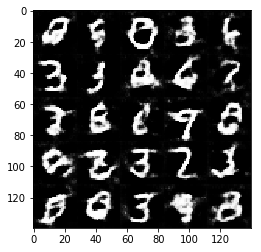

Epoch 1/2... Discriminator Loss: 1.1181... Generator Loss: 1.3149
Epoch 1/2... Discriminator Loss: 1.4424... Generator Loss: 0.5160
Epoch 1/2... Discriminator Loss: 1.0774... Generator Loss: 0.8570
Epoch 1/2... Discriminator Loss: 1.0896... Generator Loss: 1.0604
Epoch 1/2... Discriminator Loss: 1.4855... Generator Loss: 2.5663
Epoch 1/2... Discriminator Loss: 1.2950... Generator Loss: 0.6108
Epoch 1/2... Discriminator Loss: 1.2729... Generator Loss: 0.6255
Epoch 1/2... Discriminator Loss: 1.1018... Generator Loss: 1.1528
Epoch 1/2... Discriminator Loss: 1.1129... Generator Loss: 0.9210
Epoch 1/2... Discriminator Loss: 1.4099... Generator Loss: 0.4816


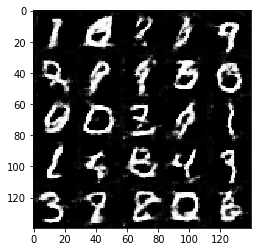

Epoch 1/2... Discriminator Loss: 1.2303... Generator Loss: 0.6720
Epoch 1/2... Discriminator Loss: 1.2664... Generator Loss: 0.6598
Epoch 1/2... Discriminator Loss: 1.3097... Generator Loss: 0.6199
Epoch 1/2... Discriminator Loss: 1.1741... Generator Loss: 1.4997
Epoch 1/2... Discriminator Loss: 1.0539... Generator Loss: 0.8883
Epoch 1/2... Discriminator Loss: 1.2925... Generator Loss: 0.5669
Epoch 1/2... Discriminator Loss: 1.2214... Generator Loss: 1.5924
Epoch 1/2... Discriminator Loss: 1.1713... Generator Loss: 0.8066
Epoch 1/2... Discriminator Loss: 1.3130... Generator Loss: 0.6283
Epoch 1/2... Discriminator Loss: 1.1470... Generator Loss: 0.7668


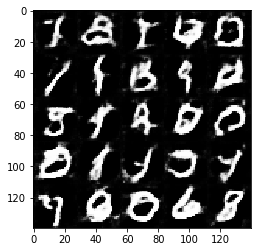

Epoch 1/2... Discriminator Loss: 1.1229... Generator Loss: 1.5691
Epoch 1/2... Discriminator Loss: 1.1279... Generator Loss: 0.8536
Epoch 1/2... Discriminator Loss: 1.0591... Generator Loss: 1.2086
Epoch 1/2... Discriminator Loss: 1.0606... Generator Loss: 0.8699
Epoch 1/2... Discriminator Loss: 1.1027... Generator Loss: 0.9740
Epoch 1/2... Discriminator Loss: 1.1637... Generator Loss: 0.7064
Epoch 1/2... Discriminator Loss: 1.1444... Generator Loss: 0.9781
Epoch 1/2... Discriminator Loss: 1.0132... Generator Loss: 1.1379
Epoch 1/2... Discriminator Loss: 1.2778... Generator Loss: 1.7027
Epoch 1/2... Discriminator Loss: 1.1140... Generator Loss: 0.7850


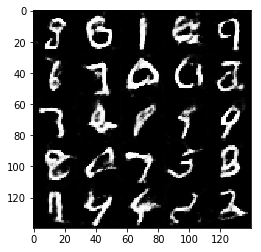

Epoch 1/2... Discriminator Loss: 1.0452... Generator Loss: 0.9103
Epoch 1/2... Discriminator Loss: 1.0016... Generator Loss: 0.9791
Epoch 1/2... Discriminator Loss: 0.9956... Generator Loss: 0.9993
Epoch 1/2... Discriminator Loss: 1.0206... Generator Loss: 1.0676
Epoch 1/2... Discriminator Loss: 1.0867... Generator Loss: 0.8753
Epoch 1/2... Discriminator Loss: 1.1626... Generator Loss: 0.7595
Epoch 1/2... Discriminator Loss: 1.1520... Generator Loss: 0.7049
Epoch 1/2... Discriminator Loss: 1.4373... Generator Loss: 0.4855
Epoch 1/2... Discriminator Loss: 0.9858... Generator Loss: 1.4909
Epoch 1/2... Discriminator Loss: 1.0331... Generator Loss: 0.9088


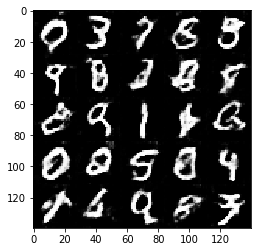

Epoch 1/2... Discriminator Loss: 0.9975... Generator Loss: 0.9309
Epoch 1/2... Discriminator Loss: 0.9884... Generator Loss: 1.2626
Epoch 1/2... Discriminator Loss: 0.9549... Generator Loss: 1.1584
Epoch 1/2... Discriminator Loss: 1.8730... Generator Loss: 0.3137
Epoch 1/2... Discriminator Loss: 1.1148... Generator Loss: 0.8862
Epoch 1/2... Discriminator Loss: 1.0288... Generator Loss: 0.9374
Epoch 1/2... Discriminator Loss: 1.1792... Generator Loss: 0.6851
Epoch 1/2... Discriminator Loss: 1.1651... Generator Loss: 0.7155
Epoch 1/2... Discriminator Loss: 1.0720... Generator Loss: 0.9160
Epoch 1/2... Discriminator Loss: 1.0798... Generator Loss: 1.2890


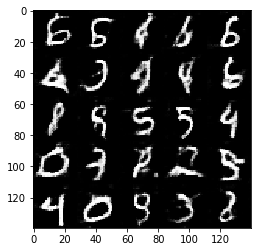

Epoch 1/2... Discriminator Loss: 1.1320... Generator Loss: 0.7454
Epoch 1/2... Discriminator Loss: 1.0630... Generator Loss: 0.9268
Epoch 1/2... Discriminator Loss: 1.1657... Generator Loss: 0.6671
Epoch 2/2... Discriminator Loss: 1.0270... Generator Loss: 1.0069
Epoch 2/2... Discriminator Loss: 1.0612... Generator Loss: 0.9694
Epoch 2/2... Discriminator Loss: 1.0640... Generator Loss: 1.0188
Epoch 2/2... Discriminator Loss: 0.9999... Generator Loss: 1.2287
Epoch 2/2... Discriminator Loss: 1.1052... Generator Loss: 1.1883
Epoch 2/2... Discriminator Loss: 0.9133... Generator Loss: 1.4780
Epoch 2/2... Discriminator Loss: 1.2369... Generator Loss: 0.6704


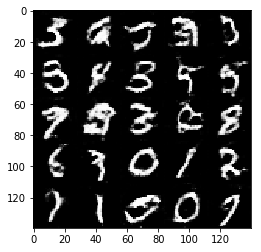

Epoch 2/2... Discriminator Loss: 0.8515... Generator Loss: 1.4983
Epoch 2/2... Discriminator Loss: 1.7636... Generator Loss: 0.3328
Epoch 2/2... Discriminator Loss: 1.0052... Generator Loss: 0.8802
Epoch 2/2... Discriminator Loss: 1.2285... Generator Loss: 0.6101
Epoch 2/2... Discriminator Loss: 0.9988... Generator Loss: 1.4219
Epoch 2/2... Discriminator Loss: 1.0832... Generator Loss: 0.7792
Epoch 2/2... Discriminator Loss: 1.3007... Generator Loss: 0.5963
Epoch 2/2... Discriminator Loss: 0.9671... Generator Loss: 1.7663
Epoch 2/2... Discriminator Loss: 1.0284... Generator Loss: 1.3940
Epoch 2/2... Discriminator Loss: 0.9665... Generator Loss: 1.6644


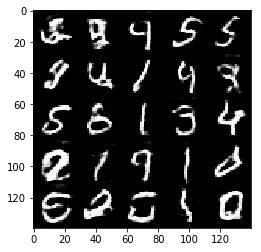

Epoch 2/2... Discriminator Loss: 1.1292... Generator Loss: 0.7449
Epoch 2/2... Discriminator Loss: 1.0378... Generator Loss: 0.9466
Epoch 2/2... Discriminator Loss: 0.9549... Generator Loss: 1.2938
Epoch 2/2... Discriminator Loss: 1.1741... Generator Loss: 0.7604
Epoch 2/2... Discriminator Loss: 1.0159... Generator Loss: 0.8593
Epoch 2/2... Discriminator Loss: 1.4806... Generator Loss: 0.4876
Epoch 2/2... Discriminator Loss: 1.1393... Generator Loss: 0.7903
Epoch 2/2... Discriminator Loss: 1.0355... Generator Loss: 1.1025
Epoch 2/2... Discriminator Loss: 0.8427... Generator Loss: 1.1110
Epoch 2/2... Discriminator Loss: 0.8658... Generator Loss: 1.4170


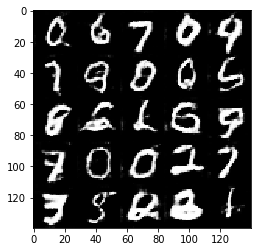

Epoch 2/2... Discriminator Loss: 0.8526... Generator Loss: 1.2236
Epoch 2/2... Discriminator Loss: 1.0790... Generator Loss: 0.8053
Epoch 2/2... Discriminator Loss: 1.4314... Generator Loss: 0.5713
Epoch 2/2... Discriminator Loss: 1.0815... Generator Loss: 0.9639
Epoch 2/2... Discriminator Loss: 0.8659... Generator Loss: 1.2913
Epoch 2/2... Discriminator Loss: 0.9507... Generator Loss: 0.9941
Epoch 2/2... Discriminator Loss: 1.0269... Generator Loss: 0.8995
Epoch 2/2... Discriminator Loss: 1.2714... Generator Loss: 0.6251
Epoch 2/2... Discriminator Loss: 0.9850... Generator Loss: 0.9810
Epoch 2/2... Discriminator Loss: 1.4090... Generator Loss: 0.5049


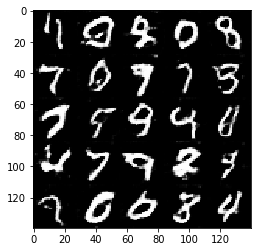

Epoch 2/2... Discriminator Loss: 1.2058... Generator Loss: 0.6957
Epoch 2/2... Discriminator Loss: 0.9679... Generator Loss: 0.9409
Epoch 2/2... Discriminator Loss: 1.0096... Generator Loss: 0.9392
Epoch 2/2... Discriminator Loss: 1.2318... Generator Loss: 0.6178
Epoch 2/2... Discriminator Loss: 0.8718... Generator Loss: 1.2084
Epoch 2/2... Discriminator Loss: 1.1691... Generator Loss: 2.4192
Epoch 2/2... Discriminator Loss: 1.0704... Generator Loss: 0.8591
Epoch 2/2... Discriminator Loss: 0.9253... Generator Loss: 1.5447
Epoch 2/2... Discriminator Loss: 0.9462... Generator Loss: 1.5767
Epoch 2/2... Discriminator Loss: 1.0677... Generator Loss: 0.7853


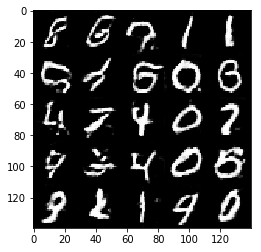

Epoch 2/2... Discriminator Loss: 0.9471... Generator Loss: 1.0220
Epoch 2/2... Discriminator Loss: 2.0080... Generator Loss: 2.9805
Epoch 2/2... Discriminator Loss: 1.2423... Generator Loss: 0.6484
Epoch 2/2... Discriminator Loss: 1.2817... Generator Loss: 0.5936
Epoch 2/2... Discriminator Loss: 0.8109... Generator Loss: 1.3587
Epoch 2/2... Discriminator Loss: 0.8720... Generator Loss: 1.3548
Epoch 2/2... Discriminator Loss: 1.2507... Generator Loss: 0.6455
Epoch 2/2... Discriminator Loss: 0.8400... Generator Loss: 1.4498
Epoch 2/2... Discriminator Loss: 1.1537... Generator Loss: 0.7034
Epoch 2/2... Discriminator Loss: 1.2761... Generator Loss: 1.7591


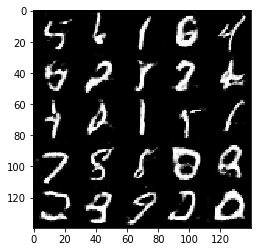

Epoch 2/2... Discriminator Loss: 0.9558... Generator Loss: 1.6814
Epoch 2/2... Discriminator Loss: 1.3369... Generator Loss: 0.6090
Epoch 2/2... Discriminator Loss: 1.5860... Generator Loss: 0.4349
Epoch 2/2... Discriminator Loss: 1.0335... Generator Loss: 0.8241
Epoch 2/2... Discriminator Loss: 0.9096... Generator Loss: 1.0280
Epoch 2/2... Discriminator Loss: 0.9969... Generator Loss: 0.9425
Epoch 2/2... Discriminator Loss: 1.0318... Generator Loss: 0.9337
Epoch 2/2... Discriminator Loss: 0.9664... Generator Loss: 1.6118
Epoch 2/2... Discriminator Loss: 0.9381... Generator Loss: 1.7804
Epoch 2/2... Discriminator Loss: 1.1128... Generator Loss: 0.7669


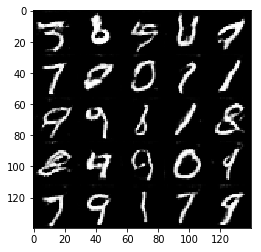

Epoch 2/2... Discriminator Loss: 0.9568... Generator Loss: 1.0199
Epoch 2/2... Discriminator Loss: 1.2653... Generator Loss: 0.6323
Epoch 2/2... Discriminator Loss: 1.1440... Generator Loss: 0.7757
Epoch 2/2... Discriminator Loss: 1.1305... Generator Loss: 0.7786
Epoch 2/2... Discriminator Loss: 1.5386... Generator Loss: 0.4524
Epoch 2/2... Discriminator Loss: 0.9134... Generator Loss: 1.0783
Epoch 2/2... Discriminator Loss: 1.2479... Generator Loss: 0.6909
Epoch 2/2... Discriminator Loss: 0.8094... Generator Loss: 1.4162
Epoch 2/2... Discriminator Loss: 0.8907... Generator Loss: 1.0714
Epoch 2/2... Discriminator Loss: 0.8032... Generator Loss: 1.4903


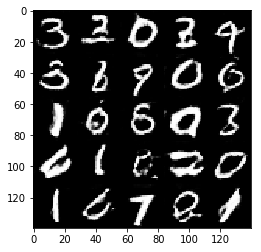

Epoch 2/2... Discriminator Loss: 0.9363... Generator Loss: 1.3383
Epoch 2/2... Discriminator Loss: 1.0358... Generator Loss: 0.8566
Epoch 2/2... Discriminator Loss: 1.0109... Generator Loss: 0.9112
Epoch 2/2... Discriminator Loss: 1.0626... Generator Loss: 0.7954
Epoch 2/2... Discriminator Loss: 0.7988... Generator Loss: 1.8593
Epoch 2/2... Discriminator Loss: 1.0227... Generator Loss: 1.4473
Epoch 2/2... Discriminator Loss: 0.8430... Generator Loss: 1.2382
Epoch 2/2... Discriminator Loss: 1.4457... Generator Loss: 0.5273
Epoch 2/2... Discriminator Loss: 1.4332... Generator Loss: 0.4991
Epoch 2/2... Discriminator Loss: 0.9549... Generator Loss: 2.2031


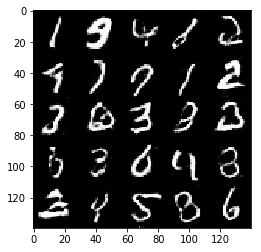

Epoch 2/2... Discriminator Loss: 0.8823... Generator Loss: 1.3903
Epoch 2/2... Discriminator Loss: 0.9564... Generator Loss: 0.9116
Epoch 2/2... Discriminator Loss: 0.9011... Generator Loss: 1.2368
Epoch 2/2... Discriminator Loss: 0.9235... Generator Loss: 1.2127
Epoch 2/2... Discriminator Loss: 1.2468... Generator Loss: 0.6352
Epoch 2/2... Discriminator Loss: 0.9117... Generator Loss: 2.1836
Epoch 2/2... Discriminator Loss: 0.8851... Generator Loss: 1.0781


In [12]:
batch_size = 64
z_dim = 100
learning_rate = 0.0003
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.3786... Generator Loss: 11.4918
Epoch 1/1... Discriminator Loss: 0.4861... Generator Loss: 7.0694
Epoch 1/1... Discriminator Loss: 0.5269... Generator Loss: 2.5148
Epoch 1/1... Discriminator Loss: 0.5191... Generator Loss: 6.4475
Epoch 1/1... Discriminator Loss: 2.5003... Generator Loss: 0.2308
Epoch 1/1... Discriminator Loss: 1.5575... Generator Loss: 0.6075
Epoch 1/1... Discriminator Loss: 2.9920... Generator Loss: 7.5514
Epoch 1/1... Discriminator Loss: 1.0444... Generator Loss: 0.8830
Epoch 1/1... Discriminator Loss: 0.8440... Generator Loss: 1.5772
Epoch 1/1... Discriminator Loss: 0.5443... Generator Loss: 2.4070


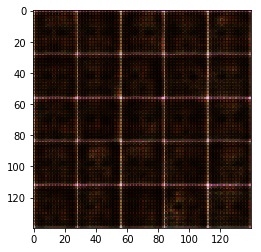

Epoch 1/1... Discriminator Loss: 0.7241... Generator Loss: 1.5899
Epoch 1/1... Discriminator Loss: 0.5929... Generator Loss: 2.1939
Epoch 1/1... Discriminator Loss: 2.9667... Generator Loss: 7.9747
Epoch 1/1... Discriminator Loss: 1.0406... Generator Loss: 0.8564
Epoch 1/1... Discriminator Loss: 0.9086... Generator Loss: 1.0355
Epoch 1/1... Discriminator Loss: 1.4101... Generator Loss: 0.7239
Epoch 1/1... Discriminator Loss: 0.9482... Generator Loss: 1.4662
Epoch 1/1... Discriminator Loss: 1.6503... Generator Loss: 0.4221
Epoch 1/1... Discriminator Loss: 1.1719... Generator Loss: 2.7061
Epoch 1/1... Discriminator Loss: 2.6073... Generator Loss: 0.1555


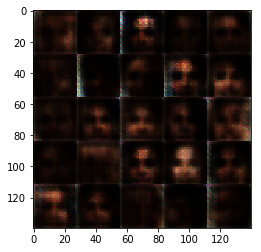

Epoch 1/1... Discriminator Loss: 1.1831... Generator Loss: 1.2113
Epoch 1/1... Discriminator Loss: 1.0829... Generator Loss: 1.7260
Epoch 1/1... Discriminator Loss: 1.5025... Generator Loss: 1.0971
Epoch 1/1... Discriminator Loss: 1.8505... Generator Loss: 0.3014
Epoch 1/1... Discriminator Loss: 1.1664... Generator Loss: 1.2249
Epoch 1/1... Discriminator Loss: 1.3010... Generator Loss: 0.9573
Epoch 1/1... Discriminator Loss: 1.0009... Generator Loss: 1.1407
Epoch 1/1... Discriminator Loss: 1.7531... Generator Loss: 0.3320
Epoch 1/1... Discriminator Loss: 0.8751... Generator Loss: 1.3708
Epoch 1/1... Discriminator Loss: 1.5635... Generator Loss: 0.5095


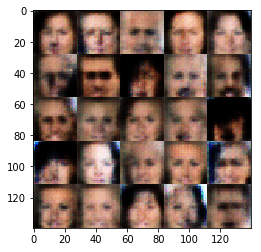

Epoch 1/1... Discriminator Loss: 1.1508... Generator Loss: 0.7412
Epoch 1/1... Discriminator Loss: 1.0891... Generator Loss: 0.8568
Epoch 1/1... Discriminator Loss: 0.7161... Generator Loss: 2.1617
Epoch 1/1... Discriminator Loss: 0.9979... Generator Loss: 0.9539
Epoch 1/1... Discriminator Loss: 1.3254... Generator Loss: 1.9091
Epoch 1/1... Discriminator Loss: 1.5027... Generator Loss: 0.8632
Epoch 1/1... Discriminator Loss: 0.9523... Generator Loss: 1.3916
Epoch 1/1... Discriminator Loss: 1.2189... Generator Loss: 0.8853
Epoch 1/1... Discriminator Loss: 1.2296... Generator Loss: 1.0667
Epoch 1/1... Discriminator Loss: 0.9686... Generator Loss: 1.0263


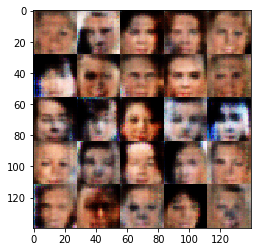

Epoch 1/1... Discriminator Loss: 1.2257... Generator Loss: 0.9674
Epoch 1/1... Discriminator Loss: 1.3153... Generator Loss: 0.7651
Epoch 1/1... Discriminator Loss: 1.6867... Generator Loss: 1.3399
Epoch 1/1... Discriminator Loss: 1.1892... Generator Loss: 1.5224
Epoch 1/1... Discriminator Loss: 1.0047... Generator Loss: 1.3528
Epoch 1/1... Discriminator Loss: 1.2125... Generator Loss: 0.8120
Epoch 1/1... Discriminator Loss: 0.7817... Generator Loss: 1.3812
Epoch 1/1... Discriminator Loss: 1.3659... Generator Loss: 1.1952
Epoch 1/1... Discriminator Loss: 1.7480... Generator Loss: 0.6279
Epoch 1/1... Discriminator Loss: 1.3648... Generator Loss: 0.8221


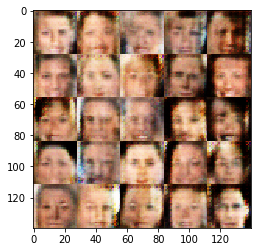

Epoch 1/1... Discriminator Loss: 1.1861... Generator Loss: 0.8143
Epoch 1/1... Discriminator Loss: 1.1782... Generator Loss: 1.2918
Epoch 1/1... Discriminator Loss: 1.3717... Generator Loss: 0.8787
Epoch 1/1... Discriminator Loss: 1.2767... Generator Loss: 0.6417
Epoch 1/1... Discriminator Loss: 1.4108... Generator Loss: 0.5026
Epoch 1/1... Discriminator Loss: 1.4524... Generator Loss: 0.5084
Epoch 1/1... Discriminator Loss: 1.1720... Generator Loss: 1.0297
Epoch 1/1... Discriminator Loss: 1.1042... Generator Loss: 1.0339
Epoch 1/1... Discriminator Loss: 1.5101... Generator Loss: 0.4472
Epoch 1/1... Discriminator Loss: 1.5430... Generator Loss: 0.4622


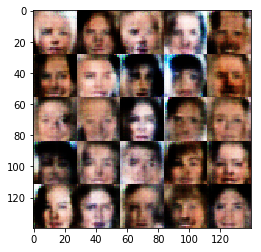

Epoch 1/1... Discriminator Loss: 1.0497... Generator Loss: 1.1231
Epoch 1/1... Discriminator Loss: 1.2472... Generator Loss: 0.6409
Epoch 1/1... Discriminator Loss: 1.5577... Generator Loss: 0.7399
Epoch 1/1... Discriminator Loss: 1.3767... Generator Loss: 0.7350
Epoch 1/1... Discriminator Loss: 1.3708... Generator Loss: 0.8132
Epoch 1/1... Discriminator Loss: 1.1851... Generator Loss: 0.8921
Epoch 1/1... Discriminator Loss: 0.9772... Generator Loss: 1.1761
Epoch 1/1... Discriminator Loss: 1.3654... Generator Loss: 0.8945
Epoch 1/1... Discriminator Loss: 0.7721... Generator Loss: 1.7740
Epoch 1/1... Discriminator Loss: 1.9314... Generator Loss: 2.5611


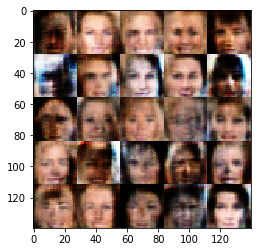

Epoch 1/1... Discriminator Loss: 0.9104... Generator Loss: 1.6101
Epoch 1/1... Discriminator Loss: 1.3050... Generator Loss: 0.6647
Epoch 1/1... Discriminator Loss: 1.3059... Generator Loss: 0.9417
Epoch 1/1... Discriminator Loss: 0.7206... Generator Loss: 1.5832
Epoch 1/1... Discriminator Loss: 0.9596... Generator Loss: 0.9190
Epoch 1/1... Discriminator Loss: 1.4008... Generator Loss: 0.8705
Epoch 1/1... Discriminator Loss: 1.3202... Generator Loss: 0.6463
Epoch 1/1... Discriminator Loss: 1.3818... Generator Loss: 0.8133
Epoch 1/1... Discriminator Loss: 1.3794... Generator Loss: 0.7961
Epoch 1/1... Discriminator Loss: 1.1486... Generator Loss: 0.9975


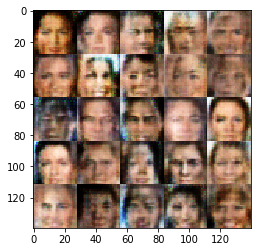

Epoch 1/1... Discriminator Loss: 1.3067... Generator Loss: 0.6399
Epoch 1/1... Discriminator Loss: 1.0093... Generator Loss: 1.5536
Epoch 1/1... Discriminator Loss: 1.4594... Generator Loss: 0.6912
Epoch 1/1... Discriminator Loss: 1.3198... Generator Loss: 1.0333
Epoch 1/1... Discriminator Loss: 1.3445... Generator Loss: 0.6560
Epoch 1/1... Discriminator Loss: 1.0230... Generator Loss: 1.4415
Epoch 1/1... Discriminator Loss: 1.2971... Generator Loss: 0.8365
Epoch 1/1... Discriminator Loss: 1.3606... Generator Loss: 0.8201
Epoch 1/1... Discriminator Loss: 1.3907... Generator Loss: 1.1864
Epoch 1/1... Discriminator Loss: 1.1851... Generator Loss: 3.0612


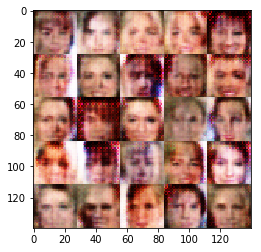

Epoch 1/1... Discriminator Loss: 1.3292... Generator Loss: 0.9497
Epoch 1/1... Discriminator Loss: 1.7722... Generator Loss: 1.3789
Epoch 1/1... Discriminator Loss: 0.6650... Generator Loss: 1.4872
Epoch 1/1... Discriminator Loss: 1.2166... Generator Loss: 0.9399
Epoch 1/1... Discriminator Loss: 1.2880... Generator Loss: 0.8269
Epoch 1/1... Discriminator Loss: 1.1181... Generator Loss: 1.1070
Epoch 1/1... Discriminator Loss: 0.9738... Generator Loss: 0.8021
Epoch 1/1... Discriminator Loss: 1.0305... Generator Loss: 1.4630
Epoch 1/1... Discriminator Loss: 1.0471... Generator Loss: 0.8522
Epoch 1/1... Discriminator Loss: 1.2651... Generator Loss: 0.7046


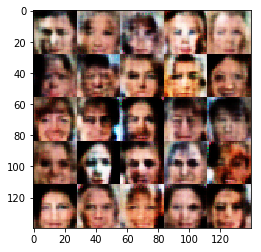

Epoch 1/1... Discriminator Loss: 1.2883... Generator Loss: 0.9095
Epoch 1/1... Discriminator Loss: 1.2946... Generator Loss: 0.9210
Epoch 1/1... Discriminator Loss: 1.2774... Generator Loss: 1.2114
Epoch 1/1... Discriminator Loss: 0.8157... Generator Loss: 1.2599
Epoch 1/1... Discriminator Loss: 0.9977... Generator Loss: 0.9919
Epoch 1/1... Discriminator Loss: 1.2530... Generator Loss: 0.6095
Epoch 1/1... Discriminator Loss: 0.8614... Generator Loss: 1.9310
Epoch 1/1... Discriminator Loss: 1.3257... Generator Loss: 0.6326
Epoch 1/1... Discriminator Loss: 1.3812... Generator Loss: 0.9195
Epoch 1/1... Discriminator Loss: 0.8855... Generator Loss: 1.0425


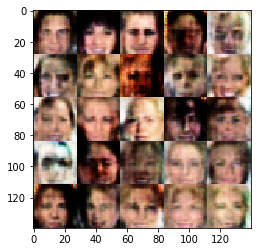

Epoch 1/1... Discriminator Loss: 1.2447... Generator Loss: 0.9425
Epoch 1/1... Discriminator Loss: 2.8138... Generator Loss: 3.3598
Epoch 1/1... Discriminator Loss: 1.0302... Generator Loss: 0.9826
Epoch 1/1... Discriminator Loss: 1.1138... Generator Loss: 1.2802
Epoch 1/1... Discriminator Loss: 1.3525... Generator Loss: 0.9877
Epoch 1/1... Discriminator Loss: 0.9560... Generator Loss: 1.2422
Epoch 1/1... Discriminator Loss: 1.1956... Generator Loss: 0.7605
Epoch 1/1... Discriminator Loss: 1.5073... Generator Loss: 0.4522
Epoch 1/1... Discriminator Loss: 0.8910... Generator Loss: 1.7910
Epoch 1/1... Discriminator Loss: 1.7561... Generator Loss: 0.2972


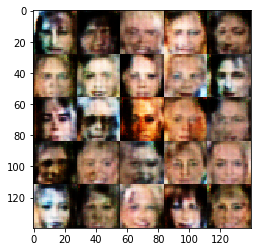

Epoch 1/1... Discriminator Loss: 1.2731... Generator Loss: 0.7646
Epoch 1/1... Discriminator Loss: 1.3436... Generator Loss: 0.5969
Epoch 1/1... Discriminator Loss: 1.7162... Generator Loss: 0.3417
Epoch 1/1... Discriminator Loss: 1.1785... Generator Loss: 0.9332
Epoch 1/1... Discriminator Loss: 0.7121... Generator Loss: 1.7282
Epoch 1/1... Discriminator Loss: 1.2612... Generator Loss: 0.6460
Epoch 1/1... Discriminator Loss: 0.7130... Generator Loss: 1.8604
Epoch 1/1... Discriminator Loss: 1.1142... Generator Loss: 1.4060
Epoch 1/1... Discriminator Loss: 1.1316... Generator Loss: 1.1672
Epoch 1/1... Discriminator Loss: 0.8831... Generator Loss: 1.4210


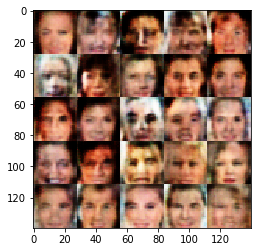

Epoch 1/1... Discriminator Loss: 1.2826... Generator Loss: 0.9699
Epoch 1/1... Discriminator Loss: 0.8160... Generator Loss: 1.9228
Epoch 1/1... Discriminator Loss: 0.7556... Generator Loss: 1.4870
Epoch 1/1... Discriminator Loss: 0.7585... Generator Loss: 1.5316
Epoch 1/1... Discriminator Loss: 1.3381... Generator Loss: 0.6877
Epoch 1/1... Discriminator Loss: 0.8053... Generator Loss: 1.4389
Epoch 1/1... Discriminator Loss: 1.6577... Generator Loss: 0.3695
Epoch 1/1... Discriminator Loss: 1.1683... Generator Loss: 0.6463
Epoch 1/1... Discriminator Loss: 1.4411... Generator Loss: 0.4843
Epoch 1/1... Discriminator Loss: 1.5730... Generator Loss: 0.4961


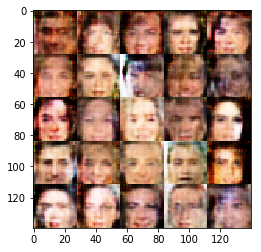

Epoch 1/1... Discriminator Loss: 1.1211... Generator Loss: 1.1113
Epoch 1/1... Discriminator Loss: 1.2972... Generator Loss: 0.6647
Epoch 1/1... Discriminator Loss: 1.5699... Generator Loss: 0.3908
Epoch 1/1... Discriminator Loss: 1.4781... Generator Loss: 2.4440
Epoch 1/1... Discriminator Loss: 1.1885... Generator Loss: 0.8763
Epoch 1/1... Discriminator Loss: 0.9456... Generator Loss: 1.1065
Epoch 1/1... Discriminator Loss: 0.8368... Generator Loss: 1.3974
Epoch 1/1... Discriminator Loss: 1.2117... Generator Loss: 1.9709
Epoch 1/1... Discriminator Loss: 1.5171... Generator Loss: 1.7378
Epoch 1/1... Discriminator Loss: 0.8961... Generator Loss: 1.9040


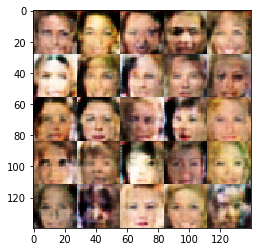

Epoch 1/1... Discriminator Loss: 1.1157... Generator Loss: 2.1337
Epoch 1/1... Discriminator Loss: 0.9409... Generator Loss: 1.2329
Epoch 1/1... Discriminator Loss: 0.6523... Generator Loss: 2.9234
Epoch 1/1... Discriminator Loss: 0.8159... Generator Loss: 1.3893
Epoch 1/1... Discriminator Loss: 1.5852... Generator Loss: 0.7852
Epoch 1/1... Discriminator Loss: 1.3071... Generator Loss: 0.7431
Epoch 1/1... Discriminator Loss: 1.1970... Generator Loss: 0.7501
Epoch 1/1... Discriminator Loss: 1.3687... Generator Loss: 0.7382
Epoch 1/1... Discriminator Loss: 1.4027... Generator Loss: 0.6717
Epoch 1/1... Discriminator Loss: 0.9442... Generator Loss: 2.1333


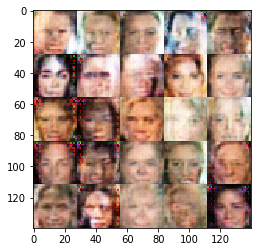

Epoch 1/1... Discriminator Loss: 1.1902... Generator Loss: 0.6610
Epoch 1/1... Discriminator Loss: 0.9258... Generator Loss: 1.0508
Epoch 1/1... Discriminator Loss: 0.9541... Generator Loss: 0.8396
Epoch 1/1... Discriminator Loss: 0.9797... Generator Loss: 1.1392
Epoch 1/1... Discriminator Loss: 1.9305... Generator Loss: 2.7254
Epoch 1/1... Discriminator Loss: 0.9062... Generator Loss: 0.9969
Epoch 1/1... Discriminator Loss: 0.8193... Generator Loss: 1.5108
Epoch 1/1... Discriminator Loss: 1.2160... Generator Loss: 1.0553
Epoch 1/1... Discriminator Loss: 1.1872... Generator Loss: 1.2643
Epoch 1/1... Discriminator Loss: 1.2105... Generator Loss: 1.1891


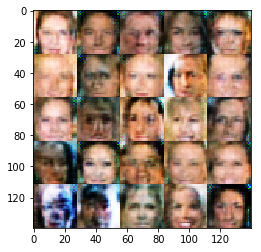

Epoch 1/1... Discriminator Loss: 1.2821... Generator Loss: 0.8273
Epoch 1/1... Discriminator Loss: 1.3270... Generator Loss: 0.7640
Epoch 1/1... Discriminator Loss: 1.1145... Generator Loss: 0.9295
Epoch 1/1... Discriminator Loss: 0.7219... Generator Loss: 1.2875
Epoch 1/1... Discriminator Loss: 1.4572... Generator Loss: 0.5023
Epoch 1/1... Discriminator Loss: 1.3966... Generator Loss: 0.6335
Epoch 1/1... Discriminator Loss: 1.2212... Generator Loss: 0.9921
Epoch 1/1... Discriminator Loss: 1.1847... Generator Loss: 1.0774
Epoch 1/1... Discriminator Loss: 1.3345... Generator Loss: 0.6952
Epoch 1/1... Discriminator Loss: 1.2866... Generator Loss: 0.7355


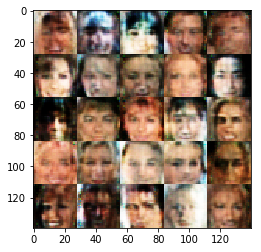

Epoch 1/1... Discriminator Loss: 1.7785... Generator Loss: 2.0081
Epoch 1/1... Discriminator Loss: 1.1307... Generator Loss: 1.3541
Epoch 1/1... Discriminator Loss: 1.5227... Generator Loss: 1.4518
Epoch 1/1... Discriminator Loss: 1.1747... Generator Loss: 0.9878
Epoch 1/1... Discriminator Loss: 0.6605... Generator Loss: 1.5794
Epoch 1/1... Discriminator Loss: 1.1260... Generator Loss: 1.2186
Epoch 1/1... Discriminator Loss: 1.0384... Generator Loss: 1.3764
Epoch 1/1... Discriminator Loss: 1.0981... Generator Loss: 0.8806
Epoch 1/1... Discriminator Loss: 1.3399... Generator Loss: 0.6243
Epoch 1/1... Discriminator Loss: 0.7769... Generator Loss: 1.4995


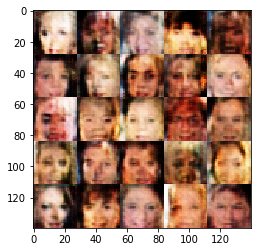

Epoch 1/1... Discriminator Loss: 1.1120... Generator Loss: 0.6848
Epoch 1/1... Discriminator Loss: 1.0902... Generator Loss: 1.1994
Epoch 1/1... Discriminator Loss: 1.0883... Generator Loss: 0.9500
Epoch 1/1... Discriminator Loss: 1.0386... Generator Loss: 0.8225
Epoch 1/1... Discriminator Loss: 1.2555... Generator Loss: 0.8693
Epoch 1/1... Discriminator Loss: 1.1938... Generator Loss: 1.6623
Epoch 1/1... Discriminator Loss: 0.8720... Generator Loss: 1.1878
Epoch 1/1... Discriminator Loss: 1.3111... Generator Loss: 0.6901
Epoch 1/1... Discriminator Loss: 1.1842... Generator Loss: 0.7227
Epoch 1/1... Discriminator Loss: 0.7653... Generator Loss: 1.9985


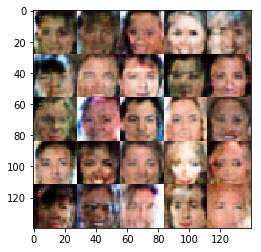

Epoch 1/1... Discriminator Loss: 0.7192... Generator Loss: 1.2979
Epoch 1/1... Discriminator Loss: 1.2235... Generator Loss: 0.8494
Epoch 1/1... Discriminator Loss: 1.2988... Generator Loss: 0.5441
Epoch 1/1... Discriminator Loss: 1.3173... Generator Loss: 0.7319
Epoch 1/1... Discriminator Loss: 1.4298... Generator Loss: 0.4878
Epoch 1/1... Discriminator Loss: 0.6146... Generator Loss: 1.6810
Epoch 1/1... Discriminator Loss: 1.6540... Generator Loss: 0.3494
Epoch 1/1... Discriminator Loss: 1.4096... Generator Loss: 0.5714
Epoch 1/1... Discriminator Loss: 1.6579... Generator Loss: 3.0474
Epoch 1/1... Discriminator Loss: 1.1460... Generator Loss: 0.8248


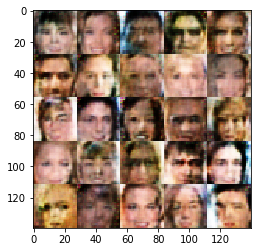

Epoch 1/1... Discriminator Loss: 0.5328... Generator Loss: 2.3872
Epoch 1/1... Discriminator Loss: 1.1975... Generator Loss: 0.8886
Epoch 1/1... Discriminator Loss: 1.2530... Generator Loss: 0.9068
Epoch 1/1... Discriminator Loss: 1.2146... Generator Loss: 0.7558
Epoch 1/1... Discriminator Loss: 0.8978... Generator Loss: 0.9157
Epoch 1/1... Discriminator Loss: 2.2759... Generator Loss: 2.0389
Epoch 1/1... Discriminator Loss: 1.2362... Generator Loss: 1.3062
Epoch 1/1... Discriminator Loss: 0.6988... Generator Loss: 1.6890
Epoch 1/1... Discriminator Loss: 1.0796... Generator Loss: 0.9408
Epoch 1/1... Discriminator Loss: 0.9351... Generator Loss: 1.2048


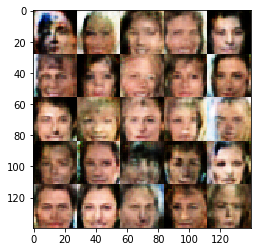

Epoch 1/1... Discriminator Loss: 1.2926... Generator Loss: 0.8758
Epoch 1/1... Discriminator Loss: 0.9290... Generator Loss: 1.0245
Epoch 1/1... Discriminator Loss: 0.7074... Generator Loss: 1.6504
Epoch 1/1... Discriminator Loss: 1.2571... Generator Loss: 0.8084
Epoch 1/1... Discriminator Loss: 0.7961... Generator Loss: 1.2503
Epoch 1/1... Discriminator Loss: 0.7682... Generator Loss: 1.4306
Epoch 1/1... Discriminator Loss: 0.8962... Generator Loss: 1.0056
Epoch 1/1... Discriminator Loss: 1.3355... Generator Loss: 0.5374
Epoch 1/1... Discriminator Loss: 0.9844... Generator Loss: 0.7964
Epoch 1/1... Discriminator Loss: 1.3033... Generator Loss: 1.0144


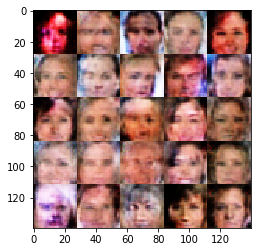

Epoch 1/1... Discriminator Loss: 1.1492... Generator Loss: 0.7524
Epoch 1/1... Discriminator Loss: 0.5455... Generator Loss: 3.3576
Epoch 1/1... Discriminator Loss: 1.3496... Generator Loss: 1.4146
Epoch 1/1... Discriminator Loss: 0.8660... Generator Loss: 2.7919
Epoch 1/1... Discriminator Loss: 0.4276... Generator Loss: 3.9775
Epoch 1/1... Discriminator Loss: 1.2281... Generator Loss: 0.9744
Epoch 1/1... Discriminator Loss: 1.0735... Generator Loss: 1.2853
Epoch 1/1... Discriminator Loss: 1.4934... Generator Loss: 1.6447
Epoch 1/1... Discriminator Loss: 1.5236... Generator Loss: 1.5952
Epoch 1/1... Discriminator Loss: 1.0629... Generator Loss: 1.3542


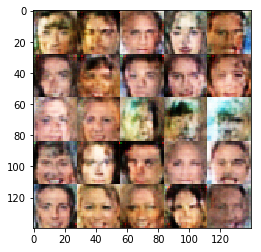

Epoch 1/1... Discriminator Loss: 1.2706... Generator Loss: 1.2248
Epoch 1/1... Discriminator Loss: 1.0792... Generator Loss: 1.0635
Epoch 1/1... Discriminator Loss: 1.0868... Generator Loss: 0.7559
Epoch 1/1... Discriminator Loss: 1.1285... Generator Loss: 0.7844
Epoch 1/1... Discriminator Loss: 0.8337... Generator Loss: 1.2582
Epoch 1/1... Discriminator Loss: 0.9734... Generator Loss: 0.8855
Epoch 1/1... Discriminator Loss: 1.3440... Generator Loss: 0.5154
Epoch 1/1... Discriminator Loss: 1.2354... Generator Loss: 0.6920
Epoch 1/1... Discriminator Loss: 0.8305... Generator Loss: 1.0231
Epoch 1/1... Discriminator Loss: 1.4017... Generator Loss: 0.8794


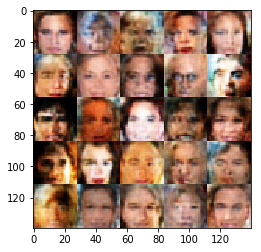

Epoch 1/1... Discriminator Loss: 0.9566... Generator Loss: 1.7245
Epoch 1/1... Discriminator Loss: 1.4171... Generator Loss: 0.7723
Epoch 1/1... Discriminator Loss: 1.0973... Generator Loss: 1.7052
Epoch 1/1... Discriminator Loss: 0.9778... Generator Loss: 1.6997
Epoch 1/1... Discriminator Loss: 0.8194... Generator Loss: 1.1187
Epoch 1/1... Discriminator Loss: 1.4069... Generator Loss: 0.4651
Epoch 1/1... Discriminator Loss: 0.8410... Generator Loss: 1.3056
Epoch 1/1... Discriminator Loss: 1.5609... Generator Loss: 0.4138
Epoch 1/1... Discriminator Loss: 0.9251... Generator Loss: 2.5212
Epoch 1/1... Discriminator Loss: 1.0759... Generator Loss: 1.0062


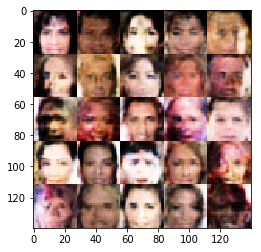

Epoch 1/1... Discriminator Loss: 1.1769... Generator Loss: 0.6837
Epoch 1/1... Discriminator Loss: 1.1079... Generator Loss: 0.6912
Epoch 1/1... Discriminator Loss: 0.8231... Generator Loss: 2.3284
Epoch 1/1... Discriminator Loss: 0.6706... Generator Loss: 1.5953
Epoch 1/1... Discriminator Loss: 1.0099... Generator Loss: 3.4020
Epoch 1/1... Discriminator Loss: 0.8308... Generator Loss: 2.7577
Epoch 1/1... Discriminator Loss: 0.9950... Generator Loss: 1.4725
Epoch 1/1... Discriminator Loss: 1.0137... Generator Loss: 0.8358
Epoch 1/1... Discriminator Loss: 0.7887... Generator Loss: 1.7569
Epoch 1/1... Discriminator Loss: 1.3475... Generator Loss: 0.8283


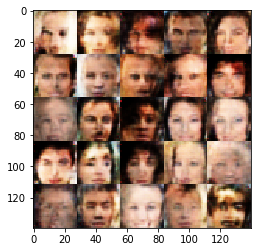

Epoch 1/1... Discriminator Loss: 1.3351... Generator Loss: 1.1159
Epoch 1/1... Discriminator Loss: 1.2579... Generator Loss: 0.6151
Epoch 1/1... Discriminator Loss: 0.8550... Generator Loss: 1.0702
Epoch 1/1... Discriminator Loss: 1.4565... Generator Loss: 0.5126
Epoch 1/1... Discriminator Loss: 1.2704... Generator Loss: 1.0221
Epoch 1/1... Discriminator Loss: 1.2115... Generator Loss: 0.9001
Epoch 1/1... Discriminator Loss: 1.4052... Generator Loss: 0.6773
Epoch 1/1... Discriminator Loss: 1.4233... Generator Loss: 0.5300
Epoch 1/1... Discriminator Loss: 1.2168... Generator Loss: 1.1875
Epoch 1/1... Discriminator Loss: 0.7109... Generator Loss: 1.3255


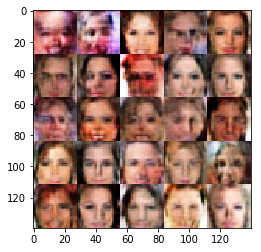

Epoch 1/1... Discriminator Loss: 0.8657... Generator Loss: 1.6058
Epoch 1/1... Discriminator Loss: 1.3116... Generator Loss: 0.5964
Epoch 1/1... Discriminator Loss: 1.4332... Generator Loss: 0.5334
Epoch 1/1... Discriminator Loss: 0.9117... Generator Loss: 1.0517
Epoch 1/1... Discriminator Loss: 0.9724... Generator Loss: 0.8912
Epoch 1/1... Discriminator Loss: 0.9258... Generator Loss: 1.9001
Epoch 1/1... Discriminator Loss: 1.1931... Generator Loss: 1.2329
Epoch 1/1... Discriminator Loss: 0.7859... Generator Loss: 1.9829
Epoch 1/1... Discriminator Loss: 1.4532... Generator Loss: 0.4315
Epoch 1/1... Discriminator Loss: 1.0788... Generator Loss: 1.0235


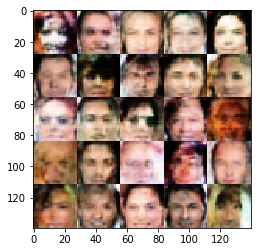

Epoch 1/1... Discriminator Loss: 1.1587... Generator Loss: 0.6951
Epoch 1/1... Discriminator Loss: 0.6942... Generator Loss: 1.2703
Epoch 1/1... Discriminator Loss: 0.6663... Generator Loss: 1.6978
Epoch 1/1... Discriminator Loss: 1.0720... Generator Loss: 1.3858
Epoch 1/1... Discriminator Loss: 0.6302... Generator Loss: 2.6800
Epoch 1/1... Discriminator Loss: 1.0788... Generator Loss: 2.0816
Epoch 1/1... Discriminator Loss: 0.8227... Generator Loss: 1.6660
Epoch 1/1... Discriminator Loss: 0.8006... Generator Loss: 1.3632
Epoch 1/1... Discriminator Loss: 0.7240... Generator Loss: 1.6630
Epoch 1/1... Discriminator Loss: 0.9432... Generator Loss: 0.9282


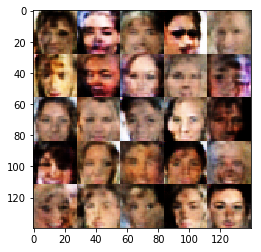

Epoch 1/1... Discriminator Loss: 0.5946... Generator Loss: 1.6961
Epoch 1/1... Discriminator Loss: 1.1118... Generator Loss: 0.9058
Epoch 1/1... Discriminator Loss: 0.8953... Generator Loss: 2.2510
Epoch 1/1... Discriminator Loss: 0.8381... Generator Loss: 1.0593
Epoch 1/1... Discriminator Loss: 1.1304... Generator Loss: 0.8313
Epoch 1/1... Discriminator Loss: 0.6234... Generator Loss: 2.0226
Epoch 1/1... Discriminator Loss: 1.2189... Generator Loss: 1.7081
Epoch 1/1... Discriminator Loss: 1.1442... Generator Loss: 2.7963
Epoch 1/1... Discriminator Loss: 1.0590... Generator Loss: 0.8858
Epoch 1/1... Discriminator Loss: 1.1513... Generator Loss: 2.1004


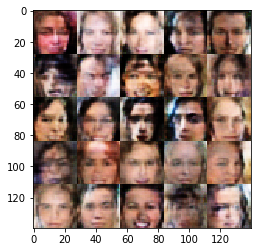

Epoch 1/1... Discriminator Loss: 0.6534... Generator Loss: 1.7516
Epoch 1/1... Discriminator Loss: 1.1156... Generator Loss: 0.6900
Epoch 1/1... Discriminator Loss: 0.5830... Generator Loss: 2.1348
Epoch 1/1... Discriminator Loss: 1.7190... Generator Loss: 2.0158
Epoch 1/1... Discriminator Loss: 1.0305... Generator Loss: 1.1448
Epoch 1/1... Discriminator Loss: 0.6803... Generator Loss: 1.5131
Epoch 1/1... Discriminator Loss: 2.8988... Generator Loss: 0.1064
Epoch 1/1... Discriminator Loss: 1.0230... Generator Loss: 1.2056
Epoch 1/1... Discriminator Loss: 1.0364... Generator Loss: 1.5505
Epoch 1/1... Discriminator Loss: 1.2615... Generator Loss: 1.2748


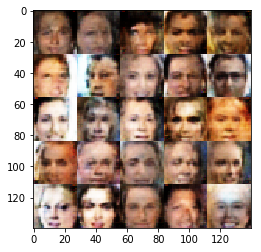

Epoch 1/1... Discriminator Loss: 0.9810... Generator Loss: 1.2447
Epoch 1/1... Discriminator Loss: 1.1226... Generator Loss: 0.9377
Epoch 1/1... Discriminator Loss: 1.7516... Generator Loss: 0.3403
Epoch 1/1... Discriminator Loss: 1.2273... Generator Loss: 0.7653
Epoch 1/1... Discriminator Loss: 0.9553... Generator Loss: 0.8960
Epoch 1/1... Discriminator Loss: 1.0285... Generator Loss: 0.7595
Epoch 1/1... Discriminator Loss: 0.8996... Generator Loss: 1.9504
Epoch 1/1... Discriminator Loss: 1.0451... Generator Loss: 1.2389
Epoch 1/1... Discriminator Loss: 0.7156... Generator Loss: 1.7559
Epoch 1/1... Discriminator Loss: 0.7454... Generator Loss: 2.0962


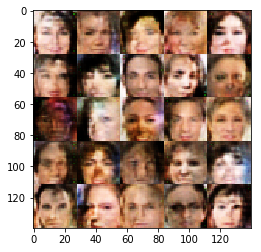

Epoch 1/1... Discriminator Loss: 1.0434... Generator Loss: 0.8346
Epoch 1/1... Discriminator Loss: 1.0686... Generator Loss: 1.8433
Epoch 1/1... Discriminator Loss: 1.1807... Generator Loss: 1.2108
Epoch 1/1... Discriminator Loss: 1.0189... Generator Loss: 0.8096
Epoch 1/1... Discriminator Loss: 1.7740... Generator Loss: 2.3622
Epoch 1/1... Discriminator Loss: 0.9459... Generator Loss: 1.4785
Epoch 1/1... Discriminator Loss: 1.3104... Generator Loss: 1.1594
Epoch 1/1... Discriminator Loss: 1.1788... Generator Loss: 1.2349
Epoch 1/1... Discriminator Loss: 1.1696... Generator Loss: 0.8261
Epoch 1/1... Discriminator Loss: 1.3282... Generator Loss: 2.4613


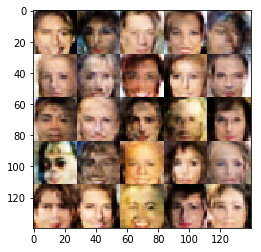

Epoch 1/1... Discriminator Loss: 0.7947... Generator Loss: 1.5260
Epoch 1/1... Discriminator Loss: 0.9759... Generator Loss: 1.1336
Epoch 1/1... Discriminator Loss: 1.1808... Generator Loss: 0.6806
Epoch 1/1... Discriminator Loss: 1.6152... Generator Loss: 0.4057
Epoch 1/1... Discriminator Loss: 0.7821... Generator Loss: 1.1683
Epoch 1/1... Discriminator Loss: 1.1518... Generator Loss: 1.2762
Epoch 1/1... Discriminator Loss: 1.6374... Generator Loss: 0.3588
Epoch 1/1... Discriminator Loss: 1.0210... Generator Loss: 1.2639
Epoch 1/1... Discriminator Loss: 0.9664... Generator Loss: 1.9588
Epoch 1/1... Discriminator Loss: 0.7766... Generator Loss: 1.4133


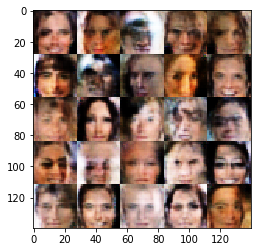

Epoch 1/1... Discriminator Loss: 0.9108... Generator Loss: 1.1094
Epoch 1/1... Discriminator Loss: 0.7997... Generator Loss: 1.7378
Epoch 1/1... Discriminator Loss: 1.3101... Generator Loss: 1.0708
Epoch 1/1... Discriminator Loss: 1.3568... Generator Loss: 0.5821
Epoch 1/1... Discriminator Loss: 0.9394... Generator Loss: 3.7708
Epoch 1/1... Discriminator Loss: 0.9067... Generator Loss: 1.1195
Epoch 1/1... Discriminator Loss: 1.3723... Generator Loss: 0.5328
Epoch 1/1... Discriminator Loss: 0.9181... Generator Loss: 1.2895
Epoch 1/1... Discriminator Loss: 0.5999... Generator Loss: 1.6095
Epoch 1/1... Discriminator Loss: 1.0893... Generator Loss: 0.7260


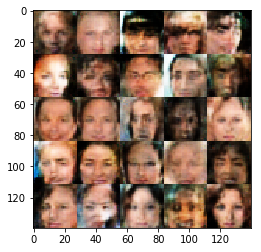

Epoch 1/1... Discriminator Loss: 0.6987... Generator Loss: 1.3458
Epoch 1/1... Discriminator Loss: 0.8453... Generator Loss: 1.2033
Epoch 1/1... Discriminator Loss: 1.0185... Generator Loss: 0.8748
Epoch 1/1... Discriminator Loss: 1.0897... Generator Loss: 1.0371
Epoch 1/1... Discriminator Loss: 0.8308... Generator Loss: 1.9839
Epoch 1/1... Discriminator Loss: 1.0332... Generator Loss: 0.9854
Epoch 1/1... Discriminator Loss: 0.6460... Generator Loss: 2.2651
Epoch 1/1... Discriminator Loss: 2.0380... Generator Loss: 3.0023
Epoch 1/1... Discriminator Loss: 1.2301... Generator Loss: 1.0249
Epoch 1/1... Discriminator Loss: 1.2398... Generator Loss: 0.5889


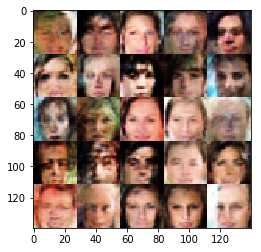

Epoch 1/1... Discriminator Loss: 1.7009... Generator Loss: 0.3666
Epoch 1/1... Discriminator Loss: 0.7687... Generator Loss: 1.4528
Epoch 1/1... Discriminator Loss: 0.8383... Generator Loss: 1.1322
Epoch 1/1... Discriminator Loss: 1.3178... Generator Loss: 0.6596
Epoch 1/1... Discriminator Loss: 0.9284... Generator Loss: 1.0893
Epoch 1/1... Discriminator Loss: 1.4713... Generator Loss: 0.5068
Epoch 1/1... Discriminator Loss: 1.0504... Generator Loss: 1.6867
Epoch 1/1... Discriminator Loss: 1.1094... Generator Loss: 0.7901
Epoch 1/1... Discriminator Loss: 1.1310... Generator Loss: 0.7096
Epoch 1/1... Discriminator Loss: 1.1662... Generator Loss: 0.7598


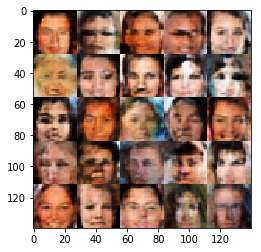

Epoch 1/1... Discriminator Loss: 1.1893... Generator Loss: 0.7170
Epoch 1/1... Discriminator Loss: 0.4479... Generator Loss: 4.2501
Epoch 1/1... Discriminator Loss: 1.3562... Generator Loss: 1.3731
Epoch 1/1... Discriminator Loss: 0.7716... Generator Loss: 1.7654
Epoch 1/1... Discriminator Loss: 1.4923... Generator Loss: 0.8432
Epoch 1/1... Discriminator Loss: 1.3842... Generator Loss: 0.4761
Epoch 1/1... Discriminator Loss: 0.8262... Generator Loss: 1.4199
Epoch 1/1... Discriminator Loss: 1.0063... Generator Loss: 1.0439
Epoch 1/1... Discriminator Loss: 1.1373... Generator Loss: 1.0454
Epoch 1/1... Discriminator Loss: 1.5348... Generator Loss: 0.4147


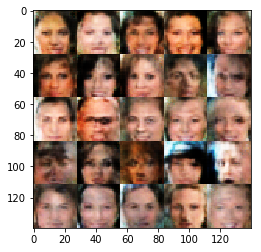

Epoch 1/1... Discriminator Loss: 0.9553... Generator Loss: 1.0946
Epoch 1/1... Discriminator Loss: 1.3390... Generator Loss: 0.5447
Epoch 1/1... Discriminator Loss: 0.9637... Generator Loss: 1.2067
Epoch 1/1... Discriminator Loss: 1.0868... Generator Loss: 1.0768
Epoch 1/1... Discriminator Loss: 1.3780... Generator Loss: 1.4319
Epoch 1/1... Discriminator Loss: 1.0593... Generator Loss: 2.0384
Epoch 1/1... Discriminator Loss: 1.1555... Generator Loss: 0.9522
Epoch 1/1... Discriminator Loss: 0.9362... Generator Loss: 1.3971
Epoch 1/1... Discriminator Loss: 0.7387... Generator Loss: 2.8115
Epoch 1/1... Discriminator Loss: 1.4377... Generator Loss: 2.0103


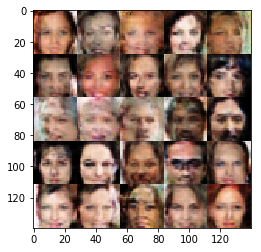

Epoch 1/1... Discriminator Loss: 0.8994... Generator Loss: 1.2459
Epoch 1/1... Discriminator Loss: 1.2703... Generator Loss: 1.1642
Epoch 1/1... Discriminator Loss: 1.4361... Generator Loss: 0.4898
Epoch 1/1... Discriminator Loss: 1.7051... Generator Loss: 0.3449
Epoch 1/1... Discriminator Loss: 1.3014... Generator Loss: 0.5500
Epoch 1/1... Discriminator Loss: 1.1153... Generator Loss: 0.8263
Epoch 1/1... Discriminator Loss: 1.5801... Generator Loss: 2.6135
Epoch 1/1... Discriminator Loss: 1.1389... Generator Loss: 0.8633
Epoch 1/1... Discriminator Loss: 1.0227... Generator Loss: 0.8608
Epoch 1/1... Discriminator Loss: 1.0372... Generator Loss: 3.7009


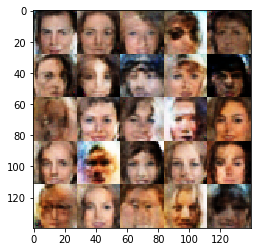

Epoch 1/1... Discriminator Loss: 1.2028... Generator Loss: 1.3214
Epoch 1/1... Discriminator Loss: 1.3213... Generator Loss: 1.4014
Epoch 1/1... Discriminator Loss: 0.9510... Generator Loss: 0.8745
Epoch 1/1... Discriminator Loss: 1.1204... Generator Loss: 0.7339
Epoch 1/1... Discriminator Loss: 1.1607... Generator Loss: 1.1134
Epoch 1/1... Discriminator Loss: 1.0308... Generator Loss: 0.9097
Epoch 1/1... Discriminator Loss: 0.8942... Generator Loss: 0.9907
Epoch 1/1... Discriminator Loss: 0.9300... Generator Loss: 0.9449
Epoch 1/1... Discriminator Loss: 1.3853... Generator Loss: 1.0222
Epoch 1/1... Discriminator Loss: 1.1172... Generator Loss: 0.7964


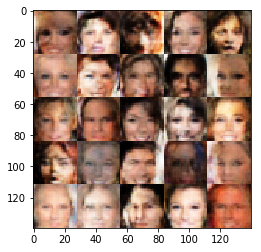

Epoch 1/1... Discriminator Loss: 0.5153... Generator Loss: 3.5928
Epoch 1/1... Discriminator Loss: 1.1519... Generator Loss: 0.7350
Epoch 1/1... Discriminator Loss: 1.0004... Generator Loss: 0.8611
Epoch 1/1... Discriminator Loss: 1.2692... Generator Loss: 0.9280
Epoch 1/1... Discriminator Loss: 0.7768... Generator Loss: 1.3271
Epoch 1/1... Discriminator Loss: 0.7558... Generator Loss: 1.4261
Epoch 1/1... Discriminator Loss: 1.0588... Generator Loss: 1.0226
Epoch 1/1... Discriminator Loss: 1.1831... Generator Loss: 0.8484
Epoch 1/1... Discriminator Loss: 0.9344... Generator Loss: 1.3692
Epoch 1/1... Discriminator Loss: 0.8675... Generator Loss: 1.2413


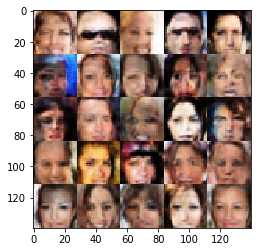

Epoch 1/1... Discriminator Loss: 1.3315... Generator Loss: 0.5612
Epoch 1/1... Discriminator Loss: 0.7217... Generator Loss: 1.4565
Epoch 1/1... Discriminator Loss: 1.0444... Generator Loss: 1.2002
Epoch 1/1... Discriminator Loss: 1.3532... Generator Loss: 0.5409
Epoch 1/1... Discriminator Loss: 1.4538... Generator Loss: 0.4692
Epoch 1/1... Discriminator Loss: 1.0489... Generator Loss: 1.3035
Epoch 1/1... Discriminator Loss: 0.9887... Generator Loss: 1.0510
Epoch 1/1... Discriminator Loss: 0.7053... Generator Loss: 1.6475
Epoch 1/1... Discriminator Loss: 1.4139... Generator Loss: 0.5476
Epoch 1/1... Discriminator Loss: 1.1126... Generator Loss: 1.2251


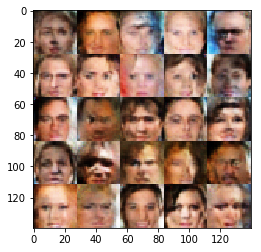

Epoch 1/1... Discriminator Loss: 1.0576... Generator Loss: 1.3338
Epoch 1/1... Discriminator Loss: 1.6452... Generator Loss: 1.1508
Epoch 1/1... Discriminator Loss: 1.2236... Generator Loss: 0.7267
Epoch 1/1... Discriminator Loss: 1.1805... Generator Loss: 1.4137
Epoch 1/1... Discriminator Loss: 1.1566... Generator Loss: 0.9683
Epoch 1/1... Discriminator Loss: 1.1390... Generator Loss: 0.8181
Epoch 1/1... Discriminator Loss: 0.9397... Generator Loss: 1.1954
Epoch 1/1... Discriminator Loss: 1.1382... Generator Loss: 0.8414
Epoch 1/1... Discriminator Loss: 0.8830... Generator Loss: 1.1938
Epoch 1/1... Discriminator Loss: 1.1391... Generator Loss: 1.1454


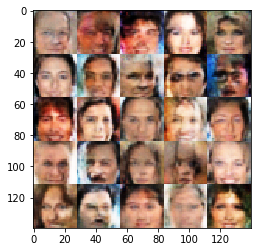

Epoch 1/1... Discriminator Loss: 1.2772... Generator Loss: 0.6115
Epoch 1/1... Discriminator Loss: 1.5936... Generator Loss: 0.4044
Epoch 1/1... Discriminator Loss: 1.1078... Generator Loss: 1.6717
Epoch 1/1... Discriminator Loss: 0.9265... Generator Loss: 1.1425
Epoch 1/1... Discriminator Loss: 1.1261... Generator Loss: 0.8554
Epoch 1/1... Discriminator Loss: 0.8591... Generator Loss: 1.0612
Epoch 1/1... Discriminator Loss: 1.0377... Generator Loss: 0.8155
Epoch 1/1... Discriminator Loss: 0.8525... Generator Loss: 1.2570
Epoch 1/1... Discriminator Loss: 1.8406... Generator Loss: 0.2973
Epoch 1/1... Discriminator Loss: 0.9937... Generator Loss: 1.0395


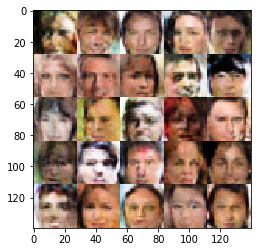

Epoch 1/1... Discriminator Loss: 0.9071... Generator Loss: 1.0900
Epoch 1/1... Discriminator Loss: 0.8013... Generator Loss: 1.7747
Epoch 1/1... Discriminator Loss: 1.1650... Generator Loss: 1.2621
Epoch 1/1... Discriminator Loss: 1.2660... Generator Loss: 0.8612
Epoch 1/1... Discriminator Loss: 1.2908... Generator Loss: 0.5700
Epoch 1/1... Discriminator Loss: 1.2588... Generator Loss: 0.5797
Epoch 1/1... Discriminator Loss: 1.0251... Generator Loss: 0.8786
Epoch 1/1... Discriminator Loss: 0.7535... Generator Loss: 2.4097
Epoch 1/1... Discriminator Loss: 1.0649... Generator Loss: 0.8089
Epoch 1/1... Discriminator Loss: 1.0233... Generator Loss: 2.0092


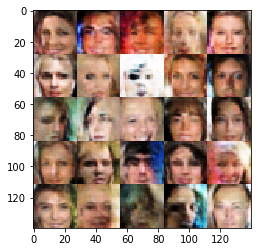

Epoch 1/1... Discriminator Loss: 1.2151... Generator Loss: 1.2143
Epoch 1/1... Discriminator Loss: 0.7296... Generator Loss: 1.4298
Epoch 1/1... Discriminator Loss: 1.1285... Generator Loss: 1.3422
Epoch 1/1... Discriminator Loss: 1.2196... Generator Loss: 0.9186
Epoch 1/1... Discriminator Loss: 1.0190... Generator Loss: 0.9347
Epoch 1/1... Discriminator Loss: 1.6927... Generator Loss: 1.2664
Epoch 1/1... Discriminator Loss: 1.0983... Generator Loss: 1.0710
Epoch 1/1... Discriminator Loss: 1.0356... Generator Loss: 1.0665
Epoch 1/1... Discriminator Loss: 0.8891... Generator Loss: 0.9526
Epoch 1/1... Discriminator Loss: 1.3643... Generator Loss: 0.5270


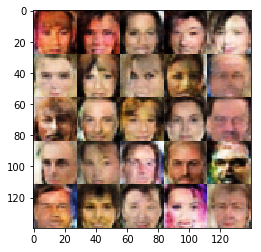

Epoch 1/1... Discriminator Loss: 0.9755... Generator Loss: 0.9878
Epoch 1/1... Discriminator Loss: 0.7500... Generator Loss: 1.8686
Epoch 1/1... Discriminator Loss: 0.7351... Generator Loss: 1.3741
Epoch 1/1... Discriminator Loss: 0.9897... Generator Loss: 1.3594
Epoch 1/1... Discriminator Loss: 0.8271... Generator Loss: 1.3450
Epoch 1/1... Discriminator Loss: 1.0750... Generator Loss: 0.7422
Epoch 1/1... Discriminator Loss: 1.0146... Generator Loss: 1.1600
Epoch 1/1... Discriminator Loss: 1.0950... Generator Loss: 0.7692
Epoch 1/1... Discriminator Loss: 0.7339... Generator Loss: 1.8492
Epoch 1/1... Discriminator Loss: 1.5812... Generator Loss: 0.3773


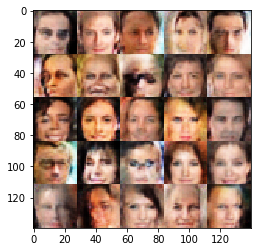

Epoch 1/1... Discriminator Loss: 1.2863... Generator Loss: 0.7383
Epoch 1/1... Discriminator Loss: 0.9446... Generator Loss: 1.2754
Epoch 1/1... Discriminator Loss: 0.9600... Generator Loss: 1.0235
Epoch 1/1... Discriminator Loss: 0.7030... Generator Loss: 2.0328
Epoch 1/1... Discriminator Loss: 0.9038... Generator Loss: 1.0745
Epoch 1/1... Discriminator Loss: 1.1030... Generator Loss: 0.8385
Epoch 1/1... Discriminator Loss: 0.9995... Generator Loss: 1.3448
Epoch 1/1... Discriminator Loss: 0.9970... Generator Loss: 0.8573
Epoch 1/1... Discriminator Loss: 1.1484... Generator Loss: 0.9132
Epoch 1/1... Discriminator Loss: 1.1852... Generator Loss: 1.2111


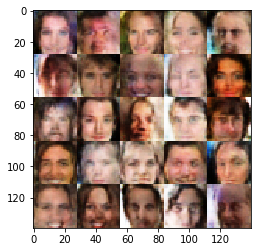

Epoch 1/1... Discriminator Loss: 0.9839... Generator Loss: 1.0073
Epoch 1/1... Discriminator Loss: 1.0680... Generator Loss: 0.8575
Epoch 1/1... Discriminator Loss: 1.4949... Generator Loss: 0.4356
Epoch 1/1... Discriminator Loss: 1.5574... Generator Loss: 0.4102
Epoch 1/1... Discriminator Loss: 0.9233... Generator Loss: 1.1533
Epoch 1/1... Discriminator Loss: 0.9798... Generator Loss: 1.5146
Epoch 1/1... Discriminator Loss: 1.2949... Generator Loss: 1.5847
Epoch 1/1... Discriminator Loss: 1.3907... Generator Loss: 1.8093
Epoch 1/1... Discriminator Loss: 1.3113... Generator Loss: 0.5352
Epoch 1/1... Discriminator Loss: 0.8888... Generator Loss: 1.0275


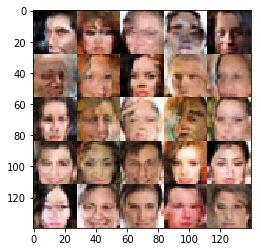

Epoch 1/1... Discriminator Loss: 0.9316... Generator Loss: 1.0989
Epoch 1/1... Discriminator Loss: 1.6764... Generator Loss: 1.4364
Epoch 1/1... Discriminator Loss: 1.2913... Generator Loss: 0.6242
Epoch 1/1... Discriminator Loss: 1.0949... Generator Loss: 1.3287
Epoch 1/1... Discriminator Loss: 1.0023... Generator Loss: 0.9220
Epoch 1/1... Discriminator Loss: 1.1571... Generator Loss: 0.6927
Epoch 1/1... Discriminator Loss: 1.1798... Generator Loss: 1.8960
Epoch 1/1... Discriminator Loss: 1.6573... Generator Loss: 2.5221
Epoch 1/1... Discriminator Loss: 1.4019... Generator Loss: 0.6214
Epoch 1/1... Discriminator Loss: 1.0232... Generator Loss: 1.3143


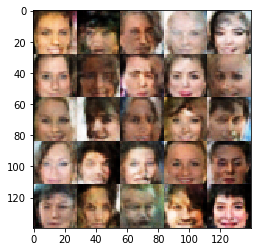

Epoch 1/1... Discriminator Loss: 1.2011... Generator Loss: 0.7862
Epoch 1/1... Discriminator Loss: 1.1909... Generator Loss: 0.8191
Epoch 1/1... Discriminator Loss: 1.3625... Generator Loss: 1.9075
Epoch 1/1... Discriminator Loss: 1.0670... Generator Loss: 0.8589
Epoch 1/1... Discriminator Loss: 1.0327... Generator Loss: 1.1440
Epoch 1/1... Discriminator Loss: 0.7823... Generator Loss: 1.3382
Epoch 1/1... Discriminator Loss: 0.8214... Generator Loss: 1.9183
Epoch 1/1... Discriminator Loss: 0.8716... Generator Loss: 1.0189
Epoch 1/1... Discriminator Loss: 0.9864... Generator Loss: 0.9241
Epoch 1/1... Discriminator Loss: 1.1829... Generator Loss: 1.3622


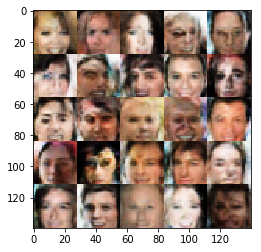

Epoch 1/1... Discriminator Loss: 1.6936... Generator Loss: 1.7230
Epoch 1/1... Discriminator Loss: 1.0942... Generator Loss: 0.7983
Epoch 1/1... Discriminator Loss: 1.0549... Generator Loss: 1.1114
Epoch 1/1... Discriminator Loss: 0.9575... Generator Loss: 1.8677
Epoch 1/1... Discriminator Loss: 1.2382... Generator Loss: 1.0940
Epoch 1/1... Discriminator Loss: 1.0485... Generator Loss: 1.3091
Epoch 1/1... Discriminator Loss: 1.4774... Generator Loss: 0.4613
Epoch 1/1... Discriminator Loss: 1.6317... Generator Loss: 0.4290
Epoch 1/1... Discriminator Loss: 0.9611... Generator Loss: 0.8733
Epoch 1/1... Discriminator Loss: 1.1312... Generator Loss: 0.9613


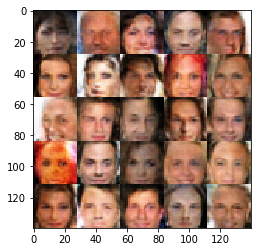

Epoch 1/1... Discriminator Loss: 1.8619... Generator Loss: 0.2686
Epoch 1/1... Discriminator Loss: 1.0593... Generator Loss: 1.2652
Epoch 1/1... Discriminator Loss: 1.1232... Generator Loss: 1.3886
Epoch 1/1... Discriminator Loss: 1.5821... Generator Loss: 0.5050
Epoch 1/1... Discriminator Loss: 1.7244... Generator Loss: 0.7758
Epoch 1/1... Discriminator Loss: 1.1026... Generator Loss: 0.8687
Epoch 1/1... Discriminator Loss: 0.7312... Generator Loss: 1.5933
Epoch 1/1... Discriminator Loss: 1.3468... Generator Loss: 0.6808
Epoch 1/1... Discriminator Loss: 1.6916... Generator Loss: 0.3320
Epoch 1/1... Discriminator Loss: 1.3330... Generator Loss: 0.9564


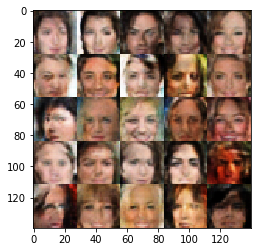

Epoch 1/1... Discriminator Loss: 0.7873... Generator Loss: 1.4225
Epoch 1/1... Discriminator Loss: 1.0117... Generator Loss: 1.1345
Epoch 1/1... Discriminator Loss: 0.7785... Generator Loss: 1.3383
Epoch 1/1... Discriminator Loss: 1.1892... Generator Loss: 0.5923
Epoch 1/1... Discriminator Loss: 1.0356... Generator Loss: 0.8800
Epoch 1/1... Discriminator Loss: 0.9538... Generator Loss: 0.9603
Epoch 1/1... Discriminator Loss: 1.6316... Generator Loss: 0.3885
Epoch 1/1... Discriminator Loss: 0.5343... Generator Loss: 2.8354
Epoch 1/1... Discriminator Loss: 1.2843... Generator Loss: 0.7194
Epoch 1/1... Discriminator Loss: 1.1540... Generator Loss: 0.7745


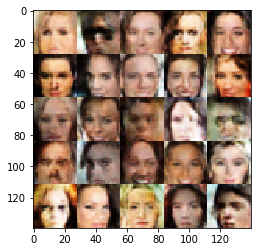

Epoch 1/1... Discriminator Loss: 1.5032... Generator Loss: 0.4519
Epoch 1/1... Discriminator Loss: 1.0285... Generator Loss: 1.0908
Epoch 1/1... Discriminator Loss: 1.1619... Generator Loss: 0.9452
Epoch 1/1... Discriminator Loss: 1.3333... Generator Loss: 1.9430
Epoch 1/1... Discriminator Loss: 1.3110... Generator Loss: 0.6655
Epoch 1/1... Discriminator Loss: 1.5260... Generator Loss: 0.4334
Epoch 1/1... Discriminator Loss: 1.1526... Generator Loss: 0.8722
Epoch 1/1... Discriminator Loss: 1.1485... Generator Loss: 0.7660
Epoch 1/1... Discriminator Loss: 1.2689... Generator Loss: 0.5812
Epoch 1/1... Discriminator Loss: 0.6068... Generator Loss: 3.2974


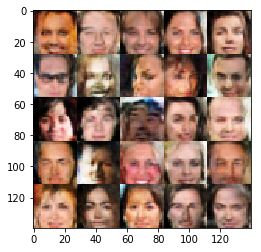

Epoch 1/1... Discriminator Loss: 1.1995... Generator Loss: 0.8379
Epoch 1/1... Discriminator Loss: 1.0974... Generator Loss: 0.7163
Epoch 1/1... Discriminator Loss: 1.0432... Generator Loss: 1.0061
Epoch 1/1... Discriminator Loss: 1.3218... Generator Loss: 0.6238
Epoch 1/1... Discriminator Loss: 0.9999... Generator Loss: 1.0969
Epoch 1/1... Discriminator Loss: 1.6343... Generator Loss: 0.3608
Epoch 1/1... Discriminator Loss: 1.3233... Generator Loss: 1.3006
Epoch 1/1... Discriminator Loss: 0.9425... Generator Loss: 1.3727
Epoch 1/1... Discriminator Loss: 1.3229... Generator Loss: 0.7287
Epoch 1/1... Discriminator Loss: 1.2099... Generator Loss: 0.6117


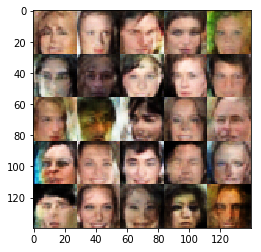

Epoch 1/1... Discriminator Loss: 1.3794... Generator Loss: 0.5163
Epoch 1/1... Discriminator Loss: 1.1411... Generator Loss: 0.8669
Epoch 1/1... Discriminator Loss: 1.1786... Generator Loss: 1.5325
Epoch 1/1... Discriminator Loss: 1.1648... Generator Loss: 1.3856
Epoch 1/1... Discriminator Loss: 1.1499... Generator Loss: 0.7002
Epoch 1/1... Discriminator Loss: 0.9404... Generator Loss: 1.0783
Epoch 1/1... Discriminator Loss: 1.0500... Generator Loss: 0.9241
Epoch 1/1... Discriminator Loss: 1.0887... Generator Loss: 1.0874
Epoch 1/1... Discriminator Loss: 1.1962... Generator Loss: 0.7743
Epoch 1/1... Discriminator Loss: 0.9777... Generator Loss: 0.9425


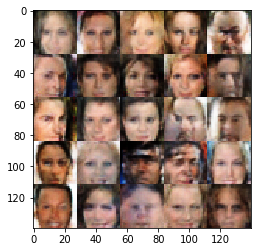

Epoch 1/1... Discriminator Loss: 1.3706... Generator Loss: 0.5267
Epoch 1/1... Discriminator Loss: 1.2014... Generator Loss: 1.1560
Epoch 1/1... Discriminator Loss: 0.9913... Generator Loss: 0.9158
Epoch 1/1... Discriminator Loss: 1.2390... Generator Loss: 0.7929
Epoch 1/1... Discriminator Loss: 1.1785... Generator Loss: 0.7045
Epoch 1/1... Discriminator Loss: 1.0860... Generator Loss: 0.9605
Epoch 1/1... Discriminator Loss: 1.1474... Generator Loss: 0.7251
Epoch 1/1... Discriminator Loss: 1.2140... Generator Loss: 0.8326
Epoch 1/1... Discriminator Loss: 1.1528... Generator Loss: 1.1051
Epoch 1/1... Discriminator Loss: 1.4452... Generator Loss: 1.0743


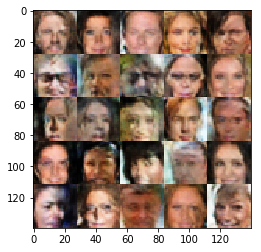

Epoch 1/1... Discriminator Loss: 1.7933... Generator Loss: 0.3398
Epoch 1/1... Discriminator Loss: 1.2790... Generator Loss: 0.9845
Epoch 1/1... Discriminator Loss: 1.1892... Generator Loss: 0.8541
Epoch 1/1... Discriminator Loss: 1.1409... Generator Loss: 1.3600
Epoch 1/1... Discriminator Loss: 1.5061... Generator Loss: 0.4456
Epoch 1/1... Discriminator Loss: 0.9832... Generator Loss: 1.2392
Epoch 1/1... Discriminator Loss: 1.2345... Generator Loss: 0.6068
Epoch 1/1... Discriminator Loss: 1.2697... Generator Loss: 0.5811
Epoch 1/1... Discriminator Loss: 0.9881... Generator Loss: 1.2323
Epoch 1/1... Discriminator Loss: 1.2932... Generator Loss: 0.7965


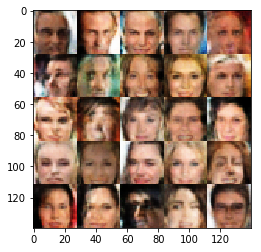

Epoch 1/1... Discriminator Loss: 1.2832... Generator Loss: 0.6076
Epoch 1/1... Discriminator Loss: 1.1879... Generator Loss: 0.7656
Epoch 1/1... Discriminator Loss: 1.2961... Generator Loss: 0.9954
Epoch 1/1... Discriminator Loss: 1.1914... Generator Loss: 1.0623
Epoch 1/1... Discriminator Loss: 1.2259... Generator Loss: 0.7082
Epoch 1/1... Discriminator Loss: 1.1207... Generator Loss: 0.7917
Epoch 1/1... Discriminator Loss: 1.1351... Generator Loss: 0.7485
Epoch 1/1... Discriminator Loss: 1.2262... Generator Loss: 0.6413
Epoch 1/1... Discriminator Loss: 1.2523... Generator Loss: 0.9058
Epoch 1/1... Discriminator Loss: 1.2267... Generator Loss: 0.7094


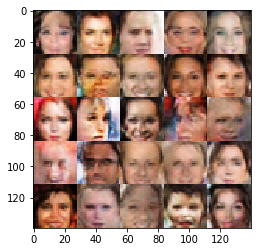

Epoch 1/1... Discriminator Loss: 1.3400... Generator Loss: 0.5971
Epoch 1/1... Discriminator Loss: 1.3220... Generator Loss: 1.0335
Epoch 1/1... Discriminator Loss: 0.6702... Generator Loss: 1.7349
Epoch 1/1... Discriminator Loss: 1.4430... Generator Loss: 0.5363
Epoch 1/1... Discriminator Loss: 1.2648... Generator Loss: 0.6482
Epoch 1/1... Discriminator Loss: 1.0893... Generator Loss: 0.7981
Epoch 1/1... Discriminator Loss: 1.0329... Generator Loss: 0.9823
Epoch 1/1... Discriminator Loss: 1.2296... Generator Loss: 0.6513
Epoch 1/1... Discriminator Loss: 1.0709... Generator Loss: 0.8272
Epoch 1/1... Discriminator Loss: 1.3292... Generator Loss: 0.7941


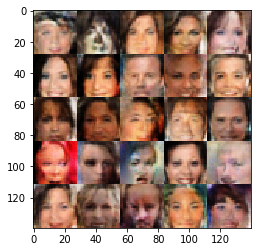

Epoch 1/1... Discriminator Loss: 0.8927... Generator Loss: 1.3895
Epoch 1/1... Discriminator Loss: 1.1390... Generator Loss: 0.8527
Epoch 1/1... Discriminator Loss: 1.3934... Generator Loss: 0.5115


In [13]:
batch_size = 32
z_dim = 100
learning_rate = 0.0004
beta1 = 0.4


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.